# Оценка балла сдачи экзамена по математике <a id="main">

* [Подготовка](#prepare)
* [Описание задачи](#intro)
* [EDA](#eda)
* [Baseline и предварительная оценка](#bl)
* [Создание и отбор признаков](#features)
* [Создание пайплайна обучения/предсказания](#pipline)
-----


## Подготовка<a id="prepare">
[Оглавление](#main)

In [525]:
# допустимые зависимости
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# оговоривалось, что дерево решений можно заимствовать встроенное
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# этих зависимостей не было в списке, если их отсутствие здесь действительно критично, прошу указать это
import os
from pathlib import Path

In [2]:
class BootstrapAggregation():
    '''
    Алгоритм, основанный на усреднении предсказаний ряда базовых алгоритмов.

    Parameters:
    -----------
    algorithm: type
        Тип базового алгоритма, участвующего в bootstrap агрегации.
        Гиперпараметры передаются сразу после указания всех параметров для BootstrapAggregation.
            ВАЖНО: передавать следует сам тип, а не экземпляр алгоритма: например,
            DecisionTreeClassifier вместо DecisionTreeClassifier().
    alg_count: int
        Количество базовых алгоритмов, участвующих в обучении.
    sample_size: int
        Размер перемешанной выборки с возвращением, участвующей в обучении.
    features_in_sample: int
        Количество признаков, участвующие в обучении.
    OOB: bool
        Метка, указывающая, следует ли активировать механизм Out-of-Bag.
        При нем выборка, не участвовавшая в процессе обучения используется для предсказания результатов,
        тем самым убирая необходимость использования кросс-валидации.
    '''

    def __init__(self, algorithm,
                 predict_type: str='regression',
                 alg_count=50,
                 sample_size=None,
                 features_in_sample=None,
                 OOB=False, **kwargs):
        if isinstance(algorithm, type):
            self.__algorithm = algorithm
        else:
            raise TypeError(
                'В "algorithm" принимается тип алгоритма, но не экземпляр базовой модели.')
        self.predict_type = predict_type
        self.__alg_count = alg_count if alg_count > 1 else 1
        self.__s_size = sample_size
        self.__s_features = features_in_sample
        self.__OOB = OOB
        self.__kw = kwargs

    def _get_bootstrap(self, data, samle_size, features_size):
        np.random.seed(self.__kw.get('random_state'))
        try:
            ind = data.index
            features = data.columns
        except AttributeError as e:
            ind = np.arange(data.shape[0])
            features = np.arange(data.shape[1])
        bootstrap_ind = np.random.choice(ind, replace=True, size=samle_size)
        feature_subsample = np.random.choice(features, replace=False, size=features_size)
        
        return feature_subsample, bootstrap_ind

    def fit(self, X, y):
        '''
        Обучает модель.

        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        '''
        self.__models = []
        self.__OOB_predicts = np.empty_like(y).astype('float')
        self.__OOB_predicts[:] = np.nan
        y_ind = np.arange(y.shape[0])
        s_features = self.__s_features
        s_size = self.__s_size
        if s_features is None:
            s_features = int(X.shape[1]**0.5)
        if s_size is None:
            s_size = X.shape[0]
        elif s_size <= 1:
            s_size = int(X.shape[0] * s_size)

        for i in range(self.__alg_count):
            b_labels, b_rows = self._get_bootstrap(X, s_size, s_features)
            try:
                b_X = X.loc[b_rows, b_labels].copy()
                b_y = y.loc[b_rows].copy()
            except AttributeError as e:
                b_X = X[b_rows][:, b_labels].copy()
                b_y = y[b_rows].copy()
            model = self.__algorithm
            self.__models.append([model(**self.__kw), b_labels])
            self.__models[i][0].fit(b_X, b_y)
            if self.__OOB:
                # TODO: оптимизировать, чтобы предсказания каждого алгоритма производились не по всей X перед отбором наблюдений
                y_pred = self.__models[i][0].predict(X[:, self.__models[i][1]])
                y_pred = np.where(np.isin(y_ind, b_rows), np.nan, y_pred)
                self.__OOB_predicts = np.vstack(
                    [self.__OOB_predicts, y_pred.copy()])
                
            if self.__kw.get('random_state') is not None:
                self.__kw['random_state'] += 1
        if self.__OOB:
            self.__OOB_predicts = np.nanmean(self.__OOB_predicts.T, axis=1)

    def predict_OOB(self):
        '''
        Отдает вероятность принадлежности объекта к классу 1 для не принимающих
        в обучении наблюдений в bootstrap выборке.
        Для каждого базового алгоритма вычисляется принадлежность к классу в self.fit() и в итоге усредняется. 


        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        return self.__OOB_predicts

    def predict_proba(self, X):
        '''
        Отдает вероятность принадлежности объекта к классу 1.

        Parameters:
        -----------
        X: array like
            Значения признаков

        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        predicts = None
        for model in self.__models:
            try:
                pred = model[0].predict(X[model[1]])
            except:
                pred = model[0].predict(X[:, model[1]])
            if predicts is None:
                predicts = pred.reshape(-1, 1)
            else:
                predicts = np.hstack(
                    (predicts.copy(), pred.reshape(-1, 1)))
        return predicts.mean(axis=1)

    def predict(self, X, prob=0.5):
        '''
        Отдает предсказания обученной модели.

        Parameters:
        -----------
        X: array like
            Значения признаков

        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        pred = self.predict_proba(X)
        if self.predict_type == 'classification':
            pred = np.where(pred < prob, 0, 1)
        return pred

    def fit_predict(self, X, y):
        '''
        Обучает модель и отдает ее предсказания.

        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной

        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        self.fit(X, y)
        return self.predict(X)

In [3]:
class Kmeans:
    '''
    Модель алгоритма кластеризации предсказаний на основе расстояний между признаками наблюдений.
    '''
    def __init__(self, k, max_iterations=50, min_distance=1e-7, N=2):
        self.__k = k
        self.__max_iterations = max_iterations
        self.__min_distance = min_distance
        self.__N = N
        
    def _distance(self, X, centroid):
        return (np.abs((X - centroid)**self.__N).sum(axis=1)**(1/self.__N))
        
    def fit(self, X, pref_feature=None):
        '''
        Обучает модель.

        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        '''
        X['cluster'] = 0

        df_distance = pd.DataFrame()
        self.__centroids = X.head(self.__k)
        if pref_feature is None:
            self.__centroids = self.__centroids.reset_index(drop=True)
        else:
            self.__centroids = self.__centroids.sort_values(pref_feature).reset_index(drop=True)
        old_centroids = self.__centroids.copy()
        
        for _ in range(1, self.__max_iterations):
            for i in range(self.__k):
                df_distance[i] = self._distance(X, self.__centroids.loc[i])
                
            X['cluster'] = df_distance.idxmin(axis=1)
            self.__centroids = X.copy().groupby('cluster').mean().reset_index(drop=True)
            if pref_feature is not None:
                self.__centroids = self.__centroids.sort_values(pref_feature).reset_index(drop=True)
                
            if abs(self.__centroids - old_centroids).sum().sum() < self.__min_distance:
                break
            old_centroids = self.__centroids.copy()
    
    def predict_distance(self, X):
        '''
        Отдает длины наблюдений до каждой центральной точки кластера.

        Parameters:
        -----------
        X: array like
            Значения признаков

        Returns
        -------
        X: list(np.array)
            Расстояния
        '''
        df_distance = pd.DataFrame()
        for i in range(self.__k):
            df_distance[i] = self._distance(X, self.__centroids.loc[i])
        return df_distance
    
    def predict(self, X):
        '''
        Отдает предсказания обученной модели.

        Parameters:
        -----------
        X: array like
            Значения признаков

        Returns
        -------
        X: np.array
            Предсказанные значения
        '''
        pred = self.predict_distance(X)
        return pred.idxmin(axis=1)
    
    def get_centroids(self):
        return self.__centroids

In [4]:
class Scaler:
    '''
    Трансформер данных, основнанный на их нормальном представлении.
    После трафнсорфмации мат. ожидание обучающей выборки будет равно нулю, а дисперсия - единице.
    '''
    def __init__(self):
        pass
    
    def fit(self, X):
        '''
        Запоминает среднее значение и дисперсию выборки, на основе которой в дальнейшем будет
        производиться трансформация
        
        Parameters:
        -----------
        X: array like
            Значения признаков
        '''
        self.__stat_dict = dict()
        for column in X.columns:
            self.__stat_dict[column] = (X[column].mean(), X[column].std())
    
    def transform(self, X):
        '''
        Преобразовывает данные на основе имеющихся ожидаемых значений и их разброса. Используется после метода fit().
        
        Parameters:
        -----------
        X: array like
            Значения признаков

        Returns
        -------
        X: np.array
            Преобразованные значения
        '''
        Xc = X.copy()
        for column in Xc.columns:
            Xc[column] = (Xc[column] - self.__stat_dict[column][0]) / self.__stat_dict[column][1]
        return Xc

In [270]:
def r2_score(y_pred: np.array, labels: np.array):
    '''
    Вычисляет коэффициент детерминации предсказанной (y_pred) и исходной выборок (labels).
    '''
    sigma2 = (labels - y_pred)**2
    sigmay2 = (labels - labels.mean())**2
    return 1 - sigma2.sum() / sigmay2.sum()

def mean_distance(clusters: dict, centroids: pd.DataFrame):
    '''
    Вычисляет среднюю дистанцию наблюдений в кластере (clusters) до
    соответственного кластера (centroids) и усредняет значения.
    '''
    dist = np.array([])

    for cluster, points in clusters.items():
        cls_dist = ((points - centroids.loc[cluster])**2).sum(1)**0.5
        dist = np.append(dist, cls_dist)
    return dist.mean()

def feature_importance(X: np.DataFrame, model:sklearn.BaseEstimator, y: pd.Series):
    '''
    Вычисляет значения метрики R2 столько раз, сколько признаков содержит выборка X.
    При каждой итерации перемешивает очередной признак, предсказывает значения целевой переменной (с помощью model)
    и вычисляет метрику с использованием исходных значений целевой переменной y.
    '''
    res_dict_test = dict()

    for clm in X.columns:
        X_shuffle_test = X.copy()
        X_shuffle_test[clm] = np.random.permutation(X_shuffle_test[clm])
        pred_test = model.predict(X_shuffle_test)
        res_dict_test[clm] = r2_score(pred_test, y)
    
    res_dict_test = sorted(res_dict_test.items(), key=lambda x: x[1])
    return res_dict_test

def evaluate_preds(train_true_values: pd.Series,
                   train_pred_values: pd.Series,
                   test_true_values: pd.Series,
                   test_pred_values: pd.Series):
    """
    Визуализирует точность предсказаний целевой переменной.
    
    """
    print("Train R2:\t" + str(round(r2_score(train_pred_values, train_true_values), 5)))
    print("Test R2:\t" + str(round(r2_score(test_pred_values, test_true_values), 5)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.plot(train_true_values, train_true_values)
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.plot(test_true_values, test_true_values)
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

def split_df(X:pd.DataFrame, split_column: str, value):
    '''
    Делит выборку X на 2 части в зависимости от порогового значения value у признака split_column.
    '''
    X_left = X.loc[X[split_column] <= value]
    X_right = X.loc[~X.index.isin(X_left.index)]
    return X_left, X_right
    
def var_after_split(X, split_column, value, target_column):
    var_origin = X[target_column].var()
    X_left, X_right = split_df(X, split_column, value)
    var_left, var_right = X_left[target_column].var(), X_right[target_column].var()
    return var_origin - (var_left * X_left.shape[0] + var_right * X_right.shape[0]) / X.shape[0]

------


## Описание задачи<a id='intro'>
[Оглавление](#main)

В данной работе на <a href="https://www.kaggle.com/c/tutors-expected-math-exam-results/overview">тренировочном датасете</a> будет предсказываться результат сдачи экзамена по математике в зависимости от выбранного репетитора.<br> Всего присутствует 11 фичей:
* Id
* age
* years_of_experience
* lesson_price
* qualification
* physics
* chemistry
* biology
* english
* geography
* history

И таргет:
* mean_exam_points


Результат будет оцениваться по коэффициенту детерминации (или доли объясненной дисперсии):
$$R^2 = 1 - \frac{\sigma^2}{\sigma_y^2}$$, где $\sigma^2$ - квадрат отклонений предсказанных значений от реальных, $\sigma_y^2$ - дисперсия целевой переменной

-----

## EDA<a id='eda'>
[Оглавление](#main)

Загрузим исходные данные и рассмотрим их в первом приближении:

In [7]:
data_path_name = 'data'

DATA_PATH = Path('./' + data_path_name)

os.system("kaggle competitions download -c tutors-expected-math-exam-results -f test.csv -p " + data_path_name)
os.system("kaggle competitions download -c tutors-expected-math-exam-results -f train.csv -p " + data_path_name)

TEST_DATASET = DATA_PATH / 'test.csv'
TRAIN_DATASET = DATA_PATH / 'train.csv'

In [8]:
df_train = pd.read_csv(TRAIN_DATASET)
df_test = pd.read_csv(TEST_DATASET)

df_train.drop(columns='Id', inplace=True)
df_test.drop(columns='Id', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns='mean_exam_points'),
                                                    df_train['mean_exam_points'],
                                                    test_size=0.30, random_state=10)

df_train.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [12]:
df_train.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [20]:
df_train.isna().sum()

age                    0
years_of_experience    0
lesson_price           0
qualification          0
physics                0
chemistry              0
biology                0
english                0
geography              0
history                0
mean_exam_points       0
dtype: int64

*Предварительно признак `Id` исключен из анализа, т.к. не должен нести какой-либо полдезной нагрузки.*

Кажется, что предварительной очистки данные не требуют: нет явных выбросов в количественных фичах, `None` значения отсутствуют, все имеющиеся признаки не являются категориальными и с ними сразу же можно работать численными методами.

Отдельно стоит отметить признаки из категории знания определенных предметов (особенно гуманитарного характера): `physics`, `chemistry`, `biology`, `english`, `geography`, `history`. Возможно, в последующем захочется избавиться от них, если они не будут в сильной мере влиять на результат, особенно учитывая то, что все они (кроме `physics`) достаточно разреженные. Особенно усиливает этот факт то, что знание последних 5 предметов не должно давать сильный прирост к знанию математики.

Также хочется посмотреть общий вид распределений признаков и челевой переменной:

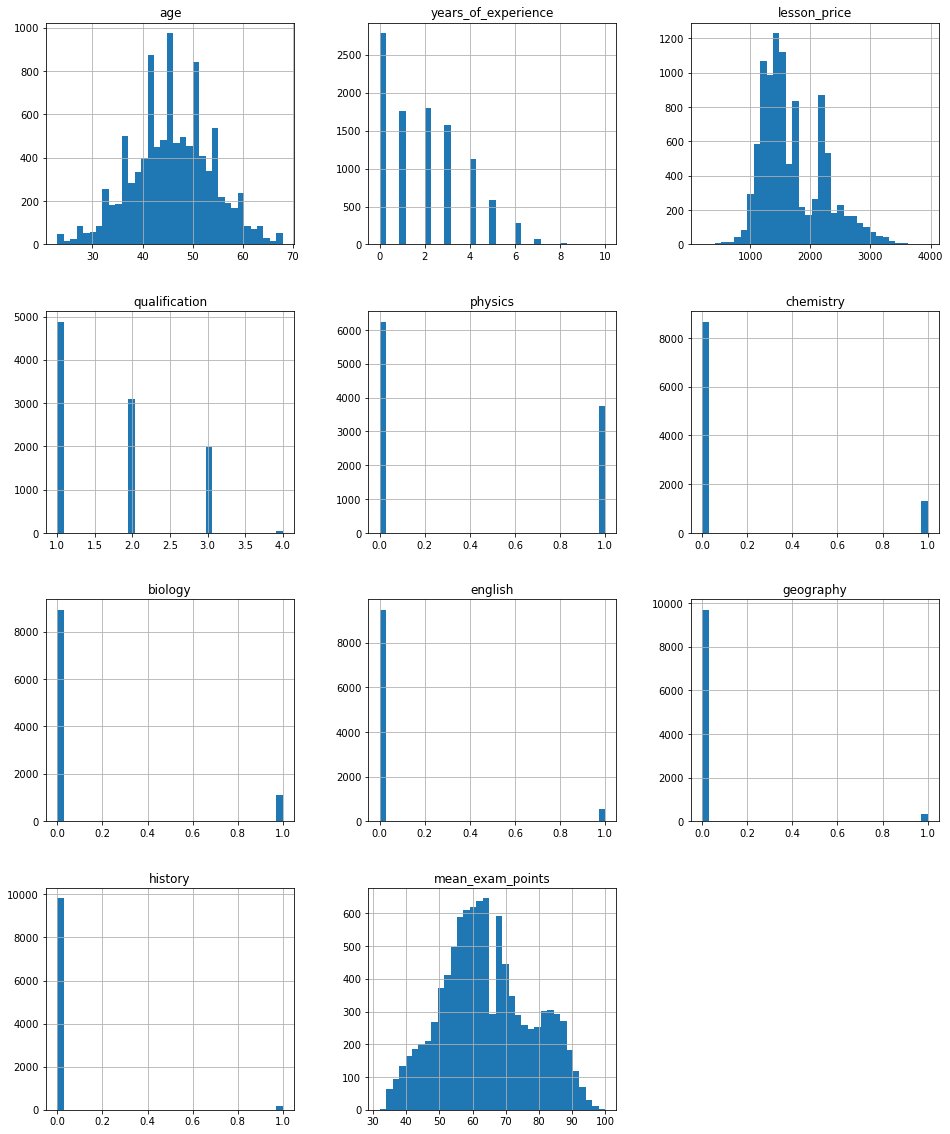

In [24]:
df_train.hist(figsize=(16,20), bins=35, grid=True, layout=(-1, 3));

На графиках `lesson_price` и `mean_exam_points` видно, что распределения представляют из себя несколько пиков, что наводит на мысль о том, что возможно выгодно будет кластеризовать выборку и строить модели на каждой ее части или номер кластера оставить как новый признак.

---------

## Baseline и предварительная оценка<a id="bl">
[Оглавление](#main)

Посмотрим опорную модель на основе модели случайного леса:

In [9]:
model = BootstrapAggregation(DecisionTreeRegressor,
                             random_state=30,
                             alg_count=300,
                             features_in_sample=len(X_train.columns),
                             sample_size=1)
model.fit(X_train, y_train)
pred = model.predict(X_train)
pred_test = model.predict(X_test)
print('train:', r2_score(pred, y_train))
print('test:', r2_score(pred_test, y_test))

train: 0.9475350854456458
test: 0.7358489769797054


Есть предположение, что модель получается несколько переобученная. Для начала подберем размер выборки для обучений: 

При доле выборки в 0.095 R2 принимает максимальное значение - 0.77674


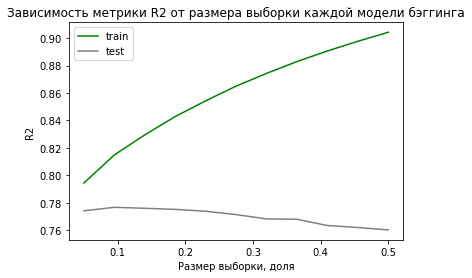

In [27]:
dict_train = dict()
dict_test = dict()
for i in np.linspace(0.05,0.5,11):
    model = BootstrapAggregation(DecisionTreeRegressor,
                             random_state=31,
                             alg_count=200,
                             features_in_sample=len(X_train.columns),
                             sample_size=i)
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    pred_test = model.predict(X_test)
    dict_train[i] = r2_score(pred, y_train)
    dict_test[i] = r2_score(pred_test, y_test)
    
# вычисление оптимальной точки
perce, r2 = max(dict_test.items(), key=lambda x: x[1])
print(f'При доле выборки в {perce} R2 принимает максимальное значение - {round(r2, 5)}')

# визуализация
plt.plot(dict_train.keys(), dict_train.values(), color='green', label='train')
plt.plot(dict_test.keys(), dict_test.values(), color='grey', label='test')
plt.title('Зависимость метрики R2 от размера выборки каждой модели бэггинга')
plt.legend(loc='best')
plt.xlabel('Размер выборки, доля')
plt.ylabel('R2')
plt.show()

Скоррекутируем начальные гиперпараметры:

In [124]:
model = BootstrapAggregation(DecisionTreeRegressor,
                             random_state=30,
                             alg_count=300,
                             features_in_sample=len(X_train.columns),
                             sample_size=0.1)
model.fit(X_train, y_train)
pred = model.predict(X_train)
pred_test = model.predict(X_test)

Train R2:	0.81755
Test R2:	0.77705


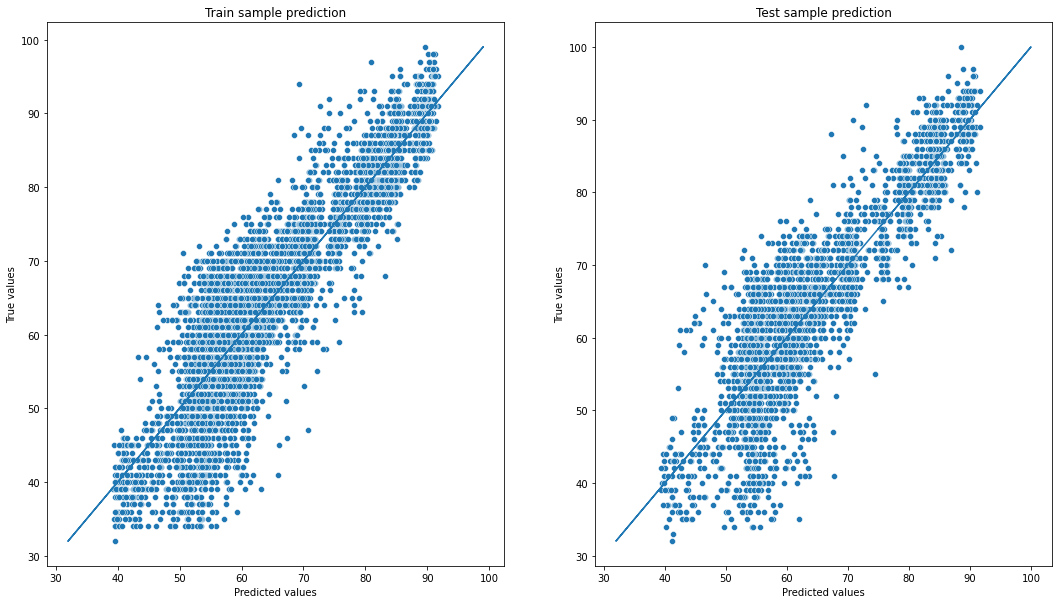

In [125]:
evaluate_preds(y_train, pred, y_test, pred_test)

Для опорной модели безо всякой обработки данных значений получились достаточно высокие. Но далее постараемся еще хотя бы несколько повысить метрику.

**Базовое значение метрики: $R^2 = 0.77705$**

--------

## Создание и отбор признаков<a id="features">
[Оглавление](#main)

### *Кластеризация*

Как было упомянуто ранее, попробуем создать признак, основанный на класетризации наблюдений.<br>
Для того, чтобы узнать оптимальное число кластеров, построим ряд моделей и вычислим среднее межгрупповое расстояние:

In [51]:
cluster_pivot = dict()
for i in range(1, 40):
    km_model = Kmeans(i)
    km_model.fit(df_train_cluster.drop(columns=clmns_to_drop), 'mean_exam_points')
    cluster_pred = km_model.predict(df_train_cluster.drop(columns=clmns_to_drop))
    df_distance = pd.DataFrame()
    dist = km_model.predict_distance(df_train_cluster)
    df_distance['distance'] = dist.min(1)
    df_distance['cluster'] = dist.idxmin(1)
    cluster_pivot[i] = df_distance.groupby('cluster').mean().reset_index(drop=True).mean()

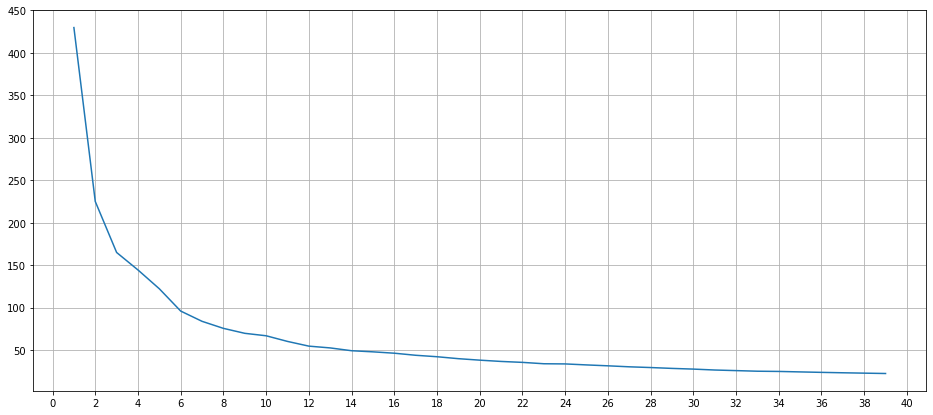

In [52]:
plt.figure(figsize = (16, 7))
plt.grid()
plt.xticks(np.arange(0, 42, 2))
plt.plot(cluster_pivot.keys(), cluster_pivot.values())
plt.show()

Так называемое "колено" образуется при 6 кластерах. Будем считать это количество оптимальным.<br>
Обучим модель `Kmeans` и создадим новый признак:

In [12]:
# т.к. фичи
clmns_to_drop = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']

# создание фичи
df_train_cluster = X_train.copy()

scaler = Scaler()
scaler.fit(df_train_cluster)
df_train_cluster = scaler.transform(df_train_cluster)

df_train_cluster['mean_exam_points'] = y_train

km_model = Kmeans(6)
km_model.fit(df_train_cluster.drop(columns=clmns_to_drop), 'mean_exam_points')

pred_train_cluster = km_model.predict(df_train_cluster.drop(columns=clmns_to_drop))
df_train_cluster['cluster'] = pred_train_cluster

X_test_scaled = scaler.transform(X_test)
pred_test_cluster = km_model.predict(X_test_scaled.drop(columns=clmns_to_drop))
X_test_scaled['cluster'] = pred_test_cluster

# предсказание с новой фичей
X_train_scaled = df_train_cluster.copy().drop(columns='mean_exam_points')
model = BootstrapAggregation(DecisionTreeRegressor,
                             random_state=30,
                             alg_count=100,
                             features_in_sample=len(X_test_scaled.columns),
                             sample_size=0.1)
model.fit(X_train_scaled, y_train)
pred_train = model.predict(X_train_scaled)
pred_test = model.predict(X_test_scaled)

print('train:', r2_score(pred_train, y_train))
print('test:', r2_score(pred_test, y_test))

train: 0.9708962741227583
test: 0.39567843886659837


Так как метрика становится значительно ниже, от идеи в такой реализации стоит отказаться. Вероятно, можно было попробовать выполнить кластеризацию без включения целевой переменной или экпериментировать с включенными в расчет предсказания фичей. Однаков, есть ощущение, что из этого ничего хорошего не выйдет.

------

### *Разбиение выборки*

Т.к. ранее было замечено, что явно признак `lesson_price` имеет 2 локальные точки экстремума, то попробуем разбить выборку на 2 части по максимизации критерия информативности (на основе разниц исходной и суммы разделленных дисперсий):

In [567]:
column = 'lesson_price'
var_dict = dict()
print('Split cond.:\t\tCriteria:')
for split_value in np.linspace(df_train[column].min(),
                               df_train[column].max(),
                               num=min(30, df_train[column].value_counts().shape[0])):
    var = var_after_split(df_train, column, split_value, 'mean_exam_points')
    var_dict[split_value] = var
    print(f'{round(split_value, 3):0}   \t\t{round(var, 3)}')

Split cond.:		Criteria:
200.0   		0.001
329.31   		0.027
458.621   		0.045
587.931   		0.104
717.241   		0.284
846.552   		0.518
975.862   		1.273
1105.172   		3.891
1234.483   		12.138
1363.793   		20.281
1493.103   		31.703
1622.414   		79.318
1751.724   		93.985
1881.034   		98.702
2010.345   		98.136
2139.655   		91.195
2268.966   		57.656
2398.276   		50.252
2527.586   		41.78
2656.897   		30.147
2786.207   		21.537
2915.517   		12.633
3044.828   		8.028
3174.138   		4.172
3303.448   		2.067
3432.759   		1.205
3562.069   		0.712
3691.379   		0.402
3820.69   		nan
3950.0   		nan


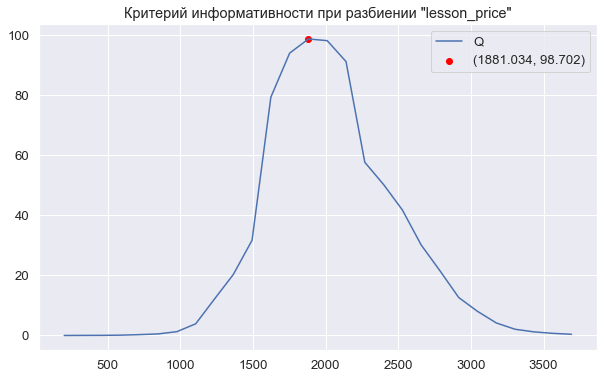

In [543]:
max_point = max(var_dict.items(), key=lambda x: x[1])

plt.figure(figsize=(10, 6))
plt.plot(var_dict.keys(), var_dict.values(), label='Q')
plt.scatter(max_point[0], max_point[1], color='red', label=(round(max_point[0], 3), round(max_point[1], 3)))
plt.title('Критерий информативности при разбиении "lesson_price"')
plt.legend(loc='best')
plt.show()

Разобьем выборку по значению `lesson_price` равному 1900 и обучим две модели для этих подвыборок, предполагая, что метрика в "левой" (меньшие значения `lesson_price`) подвыборке скорее всего будет ниже, т.к. из графика распределения предсказаний видно, что модель хуже предсказываланизкие значения целевой переменной:

In [654]:
 def model_builder(desc: any,
                   new_feature:callable=None,
                   cond_column: str='lesson_price',
                   cond_val: float or int=1900):
    '''
    Функция для облегчения поиска оптимальных признаков.
    отрисовывает значения метрик R2 на частях разбитой выборки и на всей выборки целиком.
    '''
    X_train_split = X_train.copy().drop(columns=columns_to_drop)
    X_test_split = X_test.copy().drop(columns=columns_to_drop)

    if new_feature is not None:
        X_train_split, X_test_split = new_feature(X_train_split, X_test_split)
    
    X_train_l, X_train_r = split_df(X_train_split, cond_column, cond_val)
    X_test_l, X_test_r = split_df(X_test_split, cond_column, cond_val)

    y_train_l, y_train_r = y_train[X_train_l.index], y_train[X_train_r.index]
    y_test_l, y_test_r = y_test[X_test_l.index], y_test[X_test_r.index]

    model_left = BootstrapAggregation(DecisionTreeRegressor,
                                     random_state=31,
                                     alg_count=300,
                                     features_in_sample=len(X_train_l.columns),
                                     sample_size=0.1)
    model_right = BootstrapAggregation(DecisionTreeRegressor,
                                     random_state=31,
                                     alg_count=300,
                                     features_in_sample=len(X_train_r.columns),
                                     sample_size=0.1)
    model_left.fit(X_train_l, y_train_l)
    model_right.fit(X_train_r, y_train_r)
    pred_train_l = pd.Series(model_left.predict(X_train_l), X_train_l.index)
    pred_train_r = pd.Series(model_right.predict(X_train_r), X_train_r.index)
    pred_test_l = pd.Series(model_left.predict(X_test_l), X_test_l.index)
    pred_test_r = pd.Series(model_right.predict(X_test_r), X_test_r.index)
    
    print(f'R2 values for {desc}:')
    print('')
    print(f'pred_test_l:  {round(r2_score(pred_test_l, y_test_l), 5)}')
    print(f'pred_test_r:  {round(r2_score(pred_test_r, y_test_r), 5)}')
    print('--------')
    X_test_tmp = X_test_split.copy()
    X_test_tmp['pred'] = pred_test_l
    X_test_tmp['pred'].loc[X_test_tmp[cond_column] > cond_val] = pred_test_r
    
    print(f'final:        {round(r2_score(X_test_tmp["pred"], y_test), 7)}')

In [510]:
model_builder('base split model')

R2 values for base split model:

pred_test_l:  0.43107
pred_test_r:  0.71241
--------
final:        0.7783671


Итого: метрика поднялась (была равна 0.77705), можно продолжать с этой моделью.<br>
Далее можно пробовать добавлять новые фичи, основнные на существующих, и оценивать каждую часть предсказанных выборов.

### *Генерация признаков*

Создадим колонки признаков, которые могли бы повысить метрику. Такие признаки скорее всего будут составляющими из `lesson_price`, `qualification`, `years_of_experience` и, возможно, `physics`:

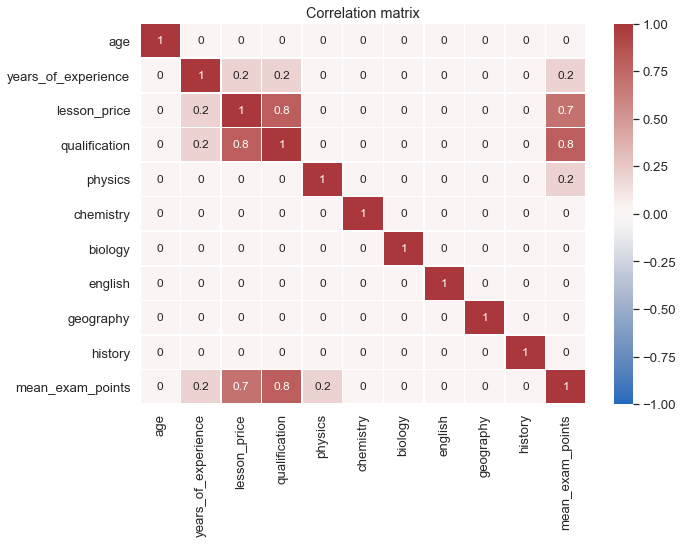

In [493]:
plt.figure(figsize = (10,7))

sns.set(font_scale=1.2)

corr_matrix = df_train.corr()
corr_matrix[np.abs(corr_matrix) < 0.1] = 0
corr_matrix = np.round(corr_matrix, 1)

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, vmin=-1, vmax=1, cmap='vlag', annot_kws={"size":12})

plt.title('Correlation matrix')
plt.show()

In [511]:
def feature1(X_train_split, X_test_split):
    q_mean = X_train_split.qualification.mean()
    X_train_split['feature1'] = (X_train_split.qualification - q_mean) / X_train_split.lesson_price
    X_test_split['feature1'] = (X_test_split.qualification - q_mean) / X_test_split.lesson_price
    return X_train_split, X_test_split

def feature2(X_train_split, X_test_split):
    lp_mean = X_train_split.lesson_price.mean()
    X_train_split['feature2'] = (X_train_split.lesson_price - lp_mean) / (X_train_split.years_of_experience + 1)
    X_test_split['feature2'] = (X_test_split.lesson_price - lp_mean) / (X_test_split.years_of_experience + 1)
    return X_train_split, X_test_split

def feature3(X_train_split, X_test_split):
    X_train_split['feature3'] = (X_train_split.qualification + 2*X_train_split.physics) / (X_train_split.years_of_experience + 1)
    X_test_split['feature3'] = (X_test_split.qualification + 2*X_test_split.physics) / (X_test_split.years_of_experience + 1)
    return X_train_split, X_test_split
    
def feature4(X_train_split, X_test_split):
    X_train_split['feature4'] = X_train_split.qualification * X_train_split.lesson_price
    X_test_split['feature4'] = X_test_split.qualification * X_test_split.lesson_price
    return X_train_split, X_test_split

def feature5(X_train_split, X_test_split):
    gr_qualification = X_train_split.copy()[['qualification', 'lesson_price']]
    gr_qualification = gr_qualification.groupby('qualification').mean()
    gr_qualification.columns = ['feature5']
    X_train_split = X_train_split.join(gr_qualification, on='qualification')
    X_test_split = X_test_split.join(gr_qualification, on='qualification')
    return X_train_split, X_test_split

def feature6(X_train_split, X_test_split):
    gr_qualification = X_train_split.copy()[['qualification']]
    gr_qualification['target'] = y_train
    gr_qualification = gr_qualification.groupby('qualification').mean()
    gr_qualification.columns = ['feature6']
    X_train_split = X_train_split.join(gr_qualification, on='qualification')
    X_test_split = X_test_split.join(gr_qualification, on='qualification')
    return X_train_split, X_test_split

In [518]:
model_builder('model with feature1', feature1)

R2 values for model with feature1:

pred_test_l:  0.43036
pred_test_r:  0.71279
--------
final:        0.7781835


In [519]:
model_builder('model with feature2', feature2)

R2 values for model with feature2:

pred_test_l:  0.43085
pred_test_r:  0.70916
--------
final:        0.7778839


In [520]:
model_builder('model with feature3', feature3)

R2 values for model with feature3:

pred_test_l:  0.43145
pred_test_r:  0.71183
--------
final:        0.7784172


In [521]:
model_builder('model with feature4', feature4)

R2 values for model with feature4:

pred_test_l:  0.42464
pred_test_r:  0.7152
--------
final:        0.776621


In [522]:
model_builder('model with feature5', feature5)

R2 values for model with feature5:

pred_test_l:  0.43153
pred_test_r:  0.71204
--------
final:        0.7784684


In [523]:
model_builder('model with feature6', feature6)

R2 values for model with feature6:

pred_test_l:  0.43153
pred_test_r:  0.71204
--------
final:        0.7784684


Можно заметить, что:
* метрику первой части датасета (left) повышают признаки **3, 5, 6**
* метрику второй части датасета (right) повышают признаки **1, 4**

Т.к. метрики при признаках 5 и 6 не отличаются, оставим только признак 5, который не зависит от целевой переменной.

------

## Создание пайплайна обучения/предсказания<a id="pipline">
[Оглавление](#main)

In [620]:
class Pipeline:
    '''
    Класс пайплайна для трансформации данных и обучения входящих в алгоритм моделей.
    '''
    def __init__(self, cond_column: str='lesson_price'):
        self.__cond_column = cond_column
        
    def fit(self, X, y):
        '''
        Обучает пайплайн:
        * проивзодит оптимизацию разбиения по критерию информативности
        * разбивает выборку на 2 части по признаку cond_column
        * создает зависимые переменные для последующего создания признаков
        * трансформирует обучающую выборку
        * обучает две модели BootstrapAggregation для имеющихся частей выборки

        Parameters:
        -----------
        X, y: array like
            Значения признаков и целевой переменной
        '''
        X_split = X.copy()
        
        # поиск порога разбиения 
        var_dict = dict()
        df = X_split.copy()
        df['target'] = y
        for split_value in np.linspace(df[self.__cond_column].min(),
                                       df[self.__cond_column].max(),
                                       num=min(30, df[self.__cond_column].value_counts().shape[0])):
            var = self._var_after_split(df, self.__cond_column, split_value, 'target')
            if var >= 0:
                var_dict[split_value] = var
        max_point = max(var_dict.items(), key=lambda x: x[1])
        self.__cond_val = max_point[0]
        
        # разбиение на 2 части
        X_l, X_r = self._split_df(X_split, self.__cond_column, self.__cond_val)
        y_l, y_r = y[X_l.index], y[X_r.index]
        
        # создание переменных для трансформации
        self.__gr_qualification_l = X_l.copy()[['qualification', 'lesson_price']]
        self.__gr_qualification_l = self.__gr_qualification_l.groupby('qualification').mean()
        self.__gr_qualification_l.columns = ['feature5']
        
        self.__qual_mean_r = X_r.qualification.mean()
        
        # трансформация обучающей выборки
        X_l['feature3'] = (X_l.qualification + 2*X_l.physics) / (X_l.years_of_experience + 1)
        X_l = X_l.join(self.__gr_qualification_l, on='qualification')
        
        X_r['feature1'] = (X_r.qualification - self.__qual_mean_r) / X_r.lesson_price
        X_r['feature4'] = X_r.qualification * X_r.lesson_price

        # инициализация и обучение моделей
        self.__model_left = BootstrapAggregation(DecisionTreeRegressor,
                                         random_state=31,
                                         alg_count=300,
                                         features_in_sample=len(X_l.columns),
                                         sample_size=0.1)
        self.__model_right = BootstrapAggregation(DecisionTreeRegressor,
                                         random_state=31,
                                         alg_count=300,
                                         features_in_sample=len(X_r.columns),
                                         sample_size=0.1)
        self.__model_left.fit(X_l, y_l)
        self.__model_right.fit(X_r, y_r)

    def predict(self, X):
        '''
        Обучает пайплайн:
        * разбивает выборку на 2 части по признаку cond_column
        * трансформирует обучаемую выборку
        * предсказывает значения на всех моделях
        * соединяет предсказания двух моделей

        Parameters:
        -----------
        X: array like
            Значения признаков
        
        Returns:
        -----------
        out: array like
            Предсказанные значения
        '''
        X_split = X.copy()
        
        # разбиение на 2 части
        X_l, X_r = self._split_df(X_split, self.__cond_column, self.__cond_val)
        
        # трансформация обучаемой выборки
        X_l['feature3'] = (X_l.qualification + 2*X_l.physics) / (X_l.years_of_experience + 1)
        X_l = X_l.join(self.__gr_qualification_l, on='qualification')
        
        X_r['feature1'] = (X_r.qualification - self.__qual_mean_r) / X_r.lesson_price
        X_r['feature4'] = X_r.qualification * X_r.lesson_price
        
        # предсказание моделей
        y_l = pd.Series(self.__model_left.predict(X_l), X_l.index)
        y_r = pd.Series(self.__model_right.predict(X_r), X_r.index)
        
        # объединение результатов
        X_split['pred'] = y_l
        X_split['pred'].loc[X_split[self.__cond_column] > self.__cond_val] = y_r
        
        return X_split['pred']
        
    @staticmethod
    def _split_df(X, split_column, value):
        X_left = X.loc[X[split_column] <= value]
        X_right = X.loc[~X.index.isin(X_left.index)]
        return X_left, X_right

    def _var_after_split(self, X, split_column, value, target_column):
        var_origin = X[target_column].var()
        X_left, X_right = self._split_df(X, split_column, value)
        var_left, var_right = X_left[target_column].var(), X_right[target_column].var()
        return var_origin - (var_left * X_left.shape[0] + var_right * X_right.shape[0]) / X.shape[0]

In [625]:
pipeline = Pipeline()
pipeline.fit(X_train, y_train)

predictd_test = pipeline.predict(X_test)
r2_score(predictd_test, y_test)

0.7792008123423123

Окончательная метрика: $R^2 = 0.7792$

In [651]:
answers = pipeline.predict(df_test)
answers = pd.DataFrame(data=answers)
answers['Id'] = answers.index + 10000
answers.columns = ['mean_exam_points', 'Id']
answers = answers[['Id','mean_exam_points']]
answers.head()


,Id,mean_exam_points
0,10000,55.093333
1,10001,62.326667
2,10002,46.935000
3,10003,91.390000
4,10004,89.345000


In [653]:
answers.to_csv(DATA_PATH / 'answers.csv', index=False)